In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import environments
import pandas as pd
import simulation_utils
from tqdm import tqdm
from models import ValueIterationNetwork, softmax, MCTS, GridWorldNode

# Example 1: Diffusion (random transitions) with Rewards in corners

In [2]:
# define the enviornment
n_rows, n_columns = 20, 20
grid_shape = (n_rows, n_columns)

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0
R[n_columns-1] = 1.0 
R[-1] = 1.0
R[-n_columns] = 1.0

gamma = 0.8
iterations = 10

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)


  0%|          | 0/10 [00:00<?, ?it/s]

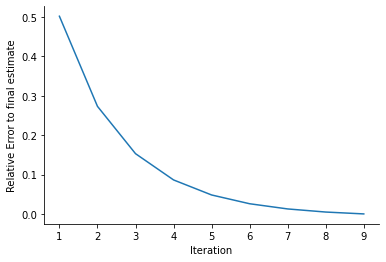

In [3]:
error = np.linalg.norm(V -  np.tile(V[-1,:], (iterations, 1)), axis=1)
plt.plot(np.arange(1, len(error)), error[1:] / np.max(error))
plt.ylabel('Relative Error to final estimate')
plt.xlabel('Iteration')
sns.despine()

Text(0.5, 1.0, 'First value estimate')

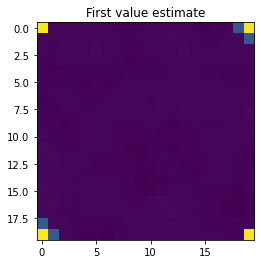

In [4]:
plt.imshow(V[0, :].reshape(grid_shape), cmap='viridis')
plt.title('First value estimate')
# plt.savefig('2dDrift_v0.pdf', dpi=300)

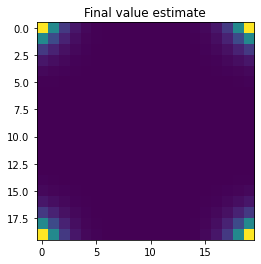

In [5]:
plt.title('Final value estimate')
plt.imshow(V[-1, :].reshape(grid_shape), cmap='viridis', vmin=0, vmax=1)
# plt.savefig('2dDrift_vf.pdf', dpi=300)

# Example 2: 1D Diffusion with Reward on one end

In [6]:
# define the enviornment
n_rows, n_columns = 1, 50

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0

iterations = 10000

# helper function
def plot_1d_value_estimates(value_estimates, gamma):
    n_steps = 7
    cc = sns.color_palette('viridis_r', n_colors=n_steps)
    for ii in range(n_steps):
        plt.plot(value_estimates[2**ii, :], label=f'{2**ii}', c=cc[ii])
    plt.plot(value_estimates[-1, :], label=f'10,000', c='k', ls='--')
    plt.ylabel('Estimated Value')
    plt.xlabel('Distance from left edge')
    plt.legend(title='Iteration')
    plt.title(r'$\gamma={}$'.format(gamma))
    sns.despine(trim=True)

def value_estimate_error(value_estimates):
    return np.linalg.norm(value_estimates[:-1:] - np.tile(value_estimates[-1,:], (iterations-1, 1)), axis=1)



  0%|          | 0/10000 [00:00<?, ?it/s]

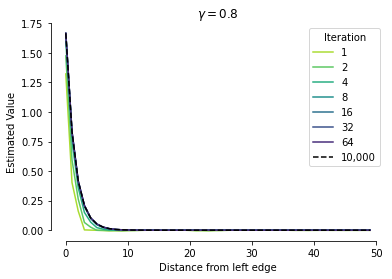

In [7]:
gamma = 0.8

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g08 = value_estimate_error(V)

plot_1d_value_estimates(V, gamma)
# plt.savefig('1dDrift_g8.pdf', dpi=300)

  0%|          | 0/10000 [00:00<?, ?it/s]

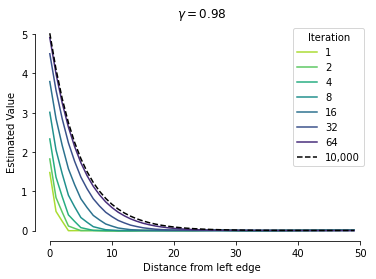

In [8]:
gamma = 0.98

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g098 = value_estimate_error(V)

plot_1d_value_estimates(V, gamma)
# plt.savefig('1dDrift_g98.pdf', dpi=300)

  0%|          | 0/10000 [00:00<?, ?it/s]

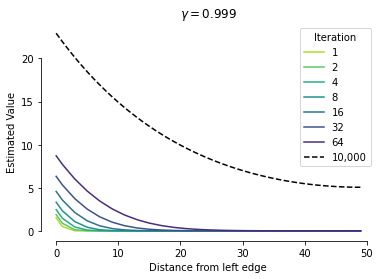

In [9]:
gamma = 0.999

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g0999 = value_estimate_error(V)


plot_1d_value_estimates(V, gamma)
# plt.savefig('1dDrift_g999.pdf', dpi=300)

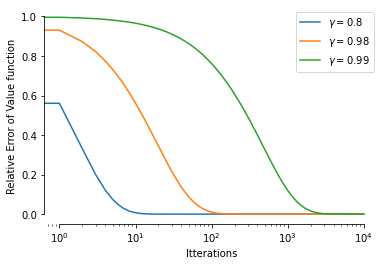

In [10]:
plt.plot(error_g08/np.max(error_g08), label=r'$\gamma = {}$'.format(0.8))
plt.plot(error_g098/np.max(error_g098), label=r'$\gamma = {}$'.format(0.98))
plt.plot(error_g0999/np.max(error_g0999), label=r'$\gamma = {}$'.format(0.99))
plt.xscale('log')
plt.legend()
plt.xlabel('Itterations')
plt.ylabel('Relative Error of Value function')
sns.despine(trim=True)
# plt.savefig('gamma_complexity.pdf', dpi=300)



In [12]:
# error = simulation_utils.evaluate_policy(mcts.get_selection_policy(beta=4), optimal_policy)


# fig, ax = plt.subplots(figsize=(12, 8))
# pos  = ax.imshow(error.reshape(1, -1), cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
# plt.plot(5, 0, '*', c='r', markersize=8)
# environments.clean_up_reward_at_end(plt.gca(), n_columns)
# plt.show()



## Example 4: Needle in a Haystack
This is designed as an example that is difficult for MCTS but easy for Value iteration. Note: these are the first simulations to derive a meaningful policy (the above were diffusion policies).


In [29]:
# define the enviornment
n_rows, n_columns = 20, 20
movement_penalty = -0.0001
slip_probability = 0.01
random_movement_on_error = False

transition_functions, state_reward_function, optimal_policy = environments.make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=movement_penalty,
    slip_probability=slip_probability,
    random_movement_on_error=random_movement_on_error
)


state_action_reward_functions = environments.get_state_action_reward_from_sucessor_rewards(
    state_reward_function, transition_functions
)


grid_shape = (n_rows, n_columns)

goal_state = 0
bottleneck_start_state = n_rows * n_columns - n_columns//2 


### Value Iteration

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Policy Error')

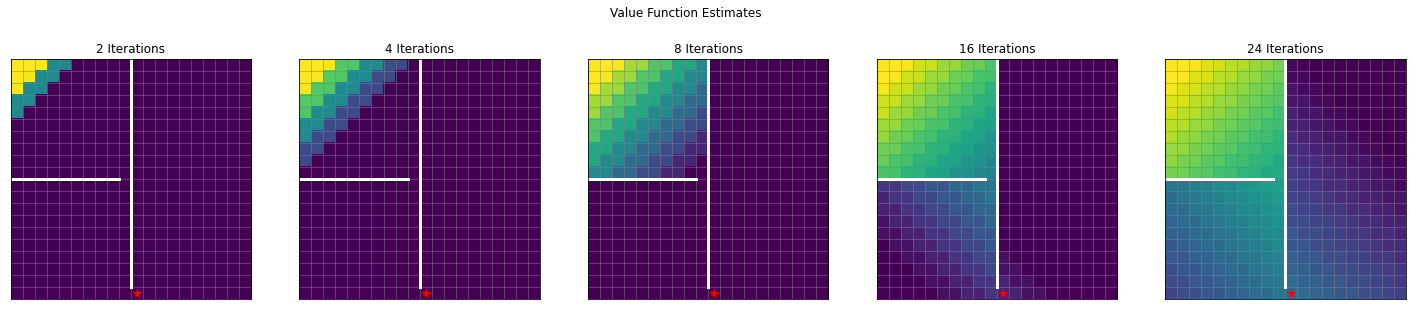

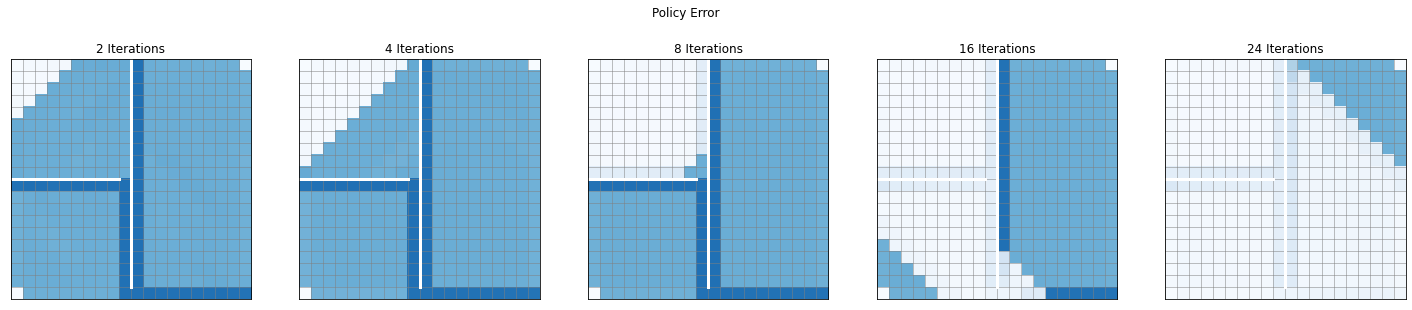

In [14]:
gamma = 0.99
beta = 5

common_model_kwargs = dict(
    transition_functions=transition_functions, 
    reward_functions=state_action_reward_functions,
    n_rows=n_rows, 
    n_columns=n_columns
)


fig_v, axes_v = plt.subplots(1, 5, figsize=(25, 5))
fig_e, axes_e = plt.subplots(1, 5, figsize=(25, 5))



# 1 iteration
def evalute_plot_vi(iterations, ax_v, ax_e):
    Q, R = ValueIterationNetwork.value_iteration(gamma=gamma, **common_model_kwargs, iterations=iterations)
    pi = softmax(Q, beta=beta)
    error = simulation_utils.evaluate_policy(pi, optimal_policy=optimal_policy)

    ax_v.imshow(R.reshape(n_rows, n_columns) )
    
    r, c = environments.get_position_from_state(bottleneck_start_state, n_columns)
    ax_v.plot(c, r, '*', c='r', markersize=8)
    environments.clean_up_thread_the_needle_plot(ax_v, n_columns, n_rows)
    ax_v.set_title(f"{iterations} Iterations")

    pos  = ax_e.imshow(error.reshape(grid_shape), 
                     cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
    environments.clean_up_thread_the_needle_plot(ax_e, n_columns, n_rows)
    ax_e.set_title(f"{iterations} Iterations")
    
evalute_plot_vi(2, axes_v[0], axes_e[0])
evalute_plot_vi(4, axes_v[1], axes_e[1])
evalute_plot_vi(8, axes_v[2], axes_e[2])
evalute_plot_vi(16, axes_v[3], axes_e[3])
evalute_plot_vi(24, axes_v[4], axes_e[4])

fig_v.suptitle('Value Function Estimates')
fig_e.suptitle('Policy Error')




In [16]:
# find the shortest path
Q, R = ValueIterationNetwork.value_iteration(gamma=gamma, **common_model_kwargs, iterations=1000)
from typing import List

def check_valid(pos, max_pos):
    return (pos > -1) and (pos < max_pos)

def get_neighbors(state: int, n_columns: int, n_rows: int) -> List[int]:
    r, c = environments.get_position_from_state(state, n_columns)
    neighbors = []
    for dr, dc in [[-1, 0], [1, 0], [0, -1], [0, 1]]:
        if check_valid(r + dr, n_rows) and check_valid(c + dc, n_columns):
            neighbors.append(
                environments.get_state_from_position(r+dr, c+dc, n_columns)
            )
    return neighbors
    
    
def find_shortest_path(state_value_function: np.ndarray, goal_state:int, start_state: int) -> np.ndarray:
    
    state = start_state
    path = []
    while state is not goal_state:
        neighbors = get_neighbors(state, n_columns, n_rows)
        values = {n: state_value_function[n] for n in neighbors if n not in path}
        state = max(values, key = values.get)
        path.append(state)
        
        
    return path

shortest_path = find_shortest_path(R, goal_state, bottleneck_start_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
%reload_ext autoreload
from models.mcts import MCTS, GridWorldNode

goals_state = 0

mcts_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=state_reward_function ,
    exploration_weight = 2**0.5 * 100,
    max_depth = 1000,
    n_sims = 100,
    gamma = 0.99,
    
)
mcts = MCTS(**mcts_kwargs)
bottleneck_start_node = GridWorldNode(bottleneck_start_state, n_actions = 4)

100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Text(0.5, 0.98, 'Successor representation for MCTS simulations')

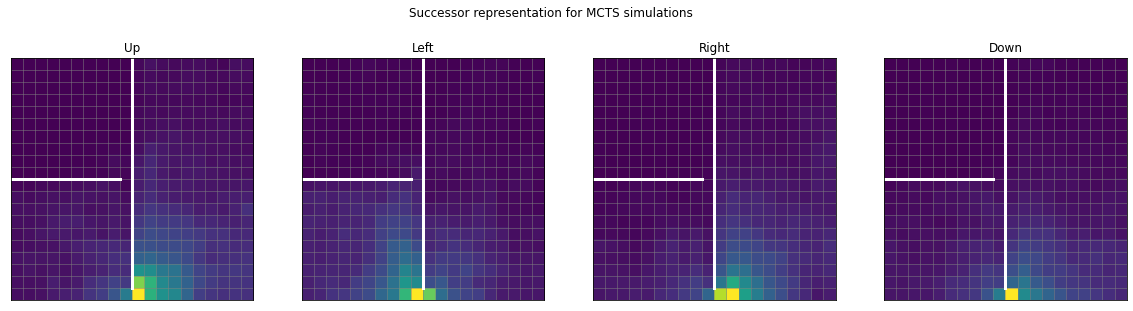

In [19]:
def get_sucessor_from_path(path, n_rows, n_columns, gamma=0.99):
    M = np.zeros(n_rows * n_columns)
    for ii, node in enumerate(path):
        M[node.state] += 1 * (gamma ** ii)
    return M


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
action_key = {0: 'Up', 1: 'Left', 2:"Right", 3:"Down"}

for a in range(4):
    successors = []
    for ii in tqdm(range(100)):
        reward, path = mcts._single_sim(bottleneck_start_node, a, return_path=True)
        M = get_sucessor_from_path(path, n_rows, n_columns)
        successors.append(M)
    successors = np.mean(successors, axis=0)

    axes[a].imshow(successors.reshape(grid_shape))
    environments.clean_up_thread_the_needle_plot(axes[a], n_columns, n_rows)
    axes[a].set_title(action_key[a])
fig.suptitle('Successor representation for MCTS simulations')

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Text(0.5, 0.98, 'Successor representation for MCTS simulations')

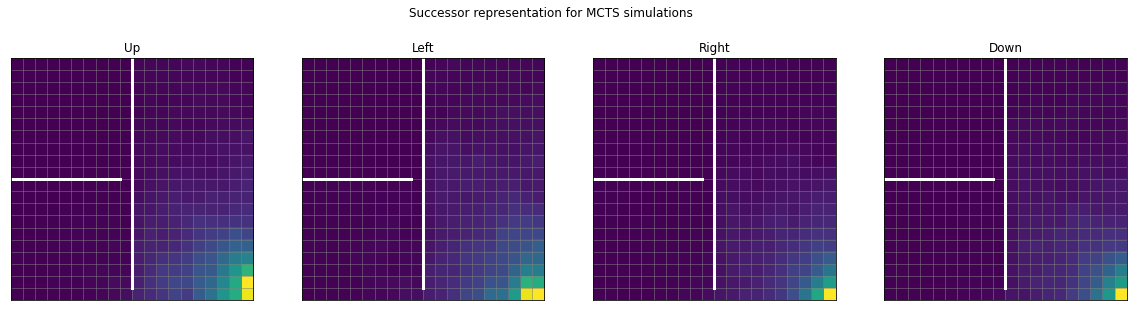

In [25]:
start_node_corner = GridWorldNode(n_rows * n_columns - 1, n_actions = 4)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
action_key = {0: 'Up', 1: 'Left', 2:"Right", 3:"Down"}

for a in range(4):
    successors = []
    for ii in tqdm(range(100)):
        reward, path = mcts._single_sim(start_node_corner, a, return_path=True)
        M = get_sucessor_from_path(path, n_rows, n_columns)
        successors.append(M)
    successors = np.mean(successors, axis=0)

    axes[a].imshow(successors.reshape(grid_shape))
    environments.clean_up_thread_the_needle_plot(axes[a], n_columns, n_rows)
    axes[a].set_title(action_key[a])
fig.suptitle('Successor representation for MCTS simulations')

In [32]:
k = 100

action_u_simulations = np.array([mcts.simulate(bottleneck_start_node, 0, k=1) for _ in tqdm(range(k))])
action_l_simulations = np.array([mcts.simulate(bottleneck_start_node, 1, k=1) for _ in tqdm(range(k))])
action_r_simulations = np.array([mcts.simulate(bottleneck_start_node, 2, k=1) for _ in tqdm(range(k))])
action_d_simulations = np.array([mcts.simulate(bottleneck_start_node, 3, k=1) for _ in tqdm(range(k))])


df = pd.DataFrame({
    'Simulated Return': np.concatenate([
        action_u_simulations,
        action_l_simulations,
        action_r_simulations,
        action_d_simulations
    ]),
    'Starting Action': 
        ['Up'] * k
        + ["Left"] * k
        + ["Right"] * k
        + ["Down"] * k
})
print(df.groupby('Starting Action').mean())
print(df.groupby('Starting Action').std())

100%|██████████| 100/100 [00:57<00:00,  1.73it/s]

                 Simulated Return
Starting Action                  
Down                    -0.006897
Left                    -0.005352
Right                   -0.009790
Up                      -0.009142
                 Simulated Return
Starting Action                  
Down                     0.026340
Left                     0.021388
Right                    0.001475
Up                       0.005813


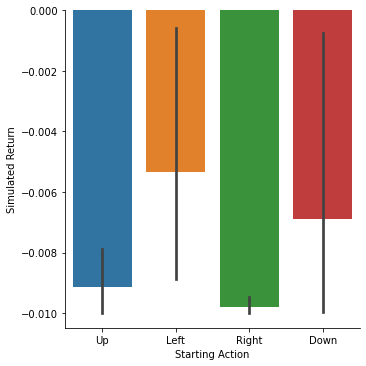

In [33]:
sns.catplot(data=df, y='Simulated Return', x='Starting Action', kind='bar')

In [39]:
from numpy.random import choice

def bootstrap_prob_correct_simulation(_df, bootstrap_samples = 100):
    up = np.array(_df.loc[df['Starting Action'] == 'Up', 'Simulated Return'])
    down = np.array(_df.loc[df['Starting Action'] == 'Down', 'Simulated Return'])
    left = np.array(_df.loc[df['Starting Action'] == 'Left', 'Simulated Return'])
    right = np.array(_df.loc[df['Starting Action'] == 'Right', 'Simulated Return'])

    def draw_sample(_df, k, bootstrap_samples = 2):
        values = []
        for ii in range(bootstrap_samples):
            v_u = np.mean([choice(up) for _ in range(k)])
            v_d = np.mean([choice(down) for _ in range(k)])
            v_l = np.mean([choice(left) for _ in range(k)])
            v_r = np.mean([choice(right) for _ in range(k)])

            values.append(v_l > np.max([v_d, v_r, v_u]))

        return np.mean(values)

    return np.array([
        draw_sample(df, ii, bootstrap_samples) for ii in tqdm(range(1, 100))
    ])



probability_correct_simulation_direction_bottleneck = bootstrap_prob_correct_simulation(df)

plt.plot(probability_correct_simulation_direction_bottleneck)
plt.xlabel('Number of Simulation')
plt.ylabel('Probability ')
sns.despine()

                 Simulated Return
Starting Action                  
Down                    -0.009899
Left                    -0.009739
Right                   -0.009999
Up                      -0.009944
                 Simulated Return
Starting Action                  
Down                     0.000944
Left                     0.001555
Right                    0.000006
Up                       0.000445


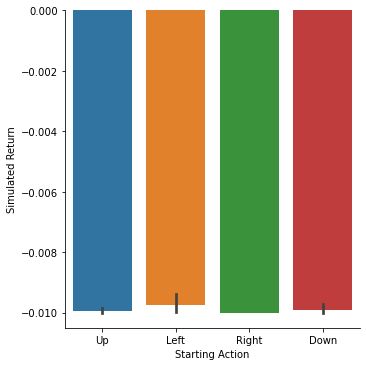

In [38]:
# pick a different start state

k = 100

action_u_simulations = np.array([mcts.simulate(start_node_corner, 0, k=1) for _ in tqdm(range(k))])
action_l_simulations = np.array([mcts.simulate(start_node_corner, 1, k=1) for _ in tqdm(range(k))])
action_r_simulations = np.array([mcts.simulate(start_node_corner, 2, k=1) for _ in tqdm(range(k))])
action_d_simulations = np.array([mcts.simulate(start_node_corner, 3, k=1) for _ in tqdm(range(k))])


df_corner = pd.DataFrame({
    'Simulated Return': np.concatenate([
        action_u_simulations,
        action_l_simulations,
        action_r_simulations,
        action_d_simulations
    ]),
    'Starting Action': 
        ['Up'] * k
        + ["Left"] * k
        + ["Right"] * k
        + ["Down"] * k
})
print(df_corner.groupby('Starting Action').mean())
print(df_corner.groupby('Starting Action').std())

sns.catplot(data=df_corner, y='Simulated Return', x='Starting Action', kind='bar')

100%|██████████| 99/99 [03:33<00:00,  2.16s/it]


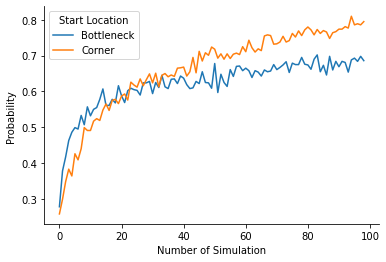

In [40]:
probability_correct_simulation_direction_bottleneck = bootstrap_prob_correct_simulation(
    df, bootstrap_samples=1000)
probability_correct_simulation_direction_corner = bootstrap_prob_correct_simulation(
    df_corner, bootstrap_samples=1000)


plt.plot(probability_correct_simulation_direction_bottleneck, label='Bottleneck')
plt.plot(probability_correct_simulation_direction_corner, label='Corner')


plt.xlabel('Number of Simulation')
plt.ylabel('Probability ')
plt.legend(title='Start Location')
sns.despine()

In [126]:
# mcts.get_simulation_depth(start_node_corner)
shortest_path = find_shortest_path(R, goal_state, start_node_corner.state)

mcts_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=state_reward_function ,
    max_depth = 100000,
    n_sims = 250,
    gamma = 0.99,
    
)
mcts = MCTS(**mcts_kwargs)

def get_average_simulation_depths(path, n_samples=1):
    
    depths = []
    for ii in tqdm(range(n_samples)):
        for jj, state in enumerate(path):
            node = GridWorldNode(state, n_actions=4)
            depths.append({
                'distance from start': jj,
                'state': state,
                'iteration': ii,
                'depth': mcts.get_simulation_depth(node)
            })
            
    return pd.DataFrame(depths)

depths = get_average_simulation_depths([s for s in reversed(shortest_path)], n_samples=250)

100%|██████████| 250/250 [48:58<00:00, 11.76s/it]


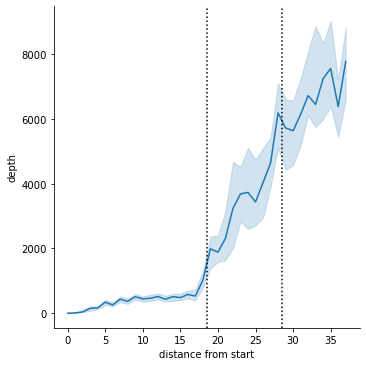

In [134]:

from scipy.stats import trim_mean
sns.relplot(data=depths, x='distance from start', y='depth', kind='line', estimator=np.median)
plt.axvline(18.5, c='k', ls=':')
plt.axvline(28.5, c='k', ls=':')

# plt.gca().set_yscale('log')


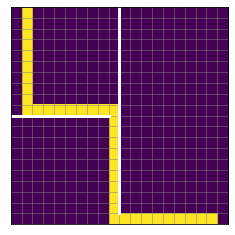

In [135]:
counts = np.zeros(n_rows * n_columns, dtype=int)
for state in depths.groupby('state').median().index:
    counts[state] = depths.loc[state, 'depth']
plt.imshow(counts.reshape(grid_shape)>0)
environments.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)

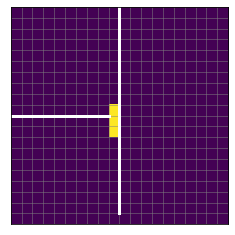

In [129]:
counts = np.zeros(n_rows * n_columns, dtype=int)
counts[189] = 1
counts[209] = 1
counts[229] = 1
plt.imshow(counts.reshape(grid_shape))
environments.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)

In [118]:
depths.groupby('state').median()

,distance from start,iteration,depth
state,,,
0,0.0,49.5,0.0
1,1.0,49.5,10.0
21,2.0,49.5,170.5
41,3.0,49.5,186.0
61,4.0,49.5,251.0
81,5.0,49.5,328.0
101,6.0,49.5,282.5
121,7.0,49.5,379.5
141,8.0,49.5,403.5
